In [44]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

def cls():
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

In [45]:
# Loading the dataset
(train_set_raw,test_set_raw,valid_set_raw),info  = tfds.load("tf_flowers",split=["train[:80%]","train[80%:90%]","train[90%:]"],as_supervised=True,with_info=True)

# Shape of dataset
train_set_raw.cardinality(), test_set_raw.cardinality(), valid_set_raw.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=2936>,
 <tf.Tensor: shape=(), dtype=int64, numpy=367>,
 <tf.Tensor: shape=(), dtype=int64, numpy=367>)

Text(0.5, 1.0, 'tulips')

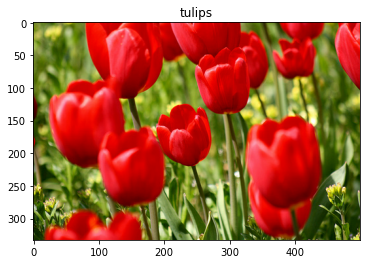

In [66]:
# If you want to extract one image
get_label_name = info.features['label'].int2str
image, label = next(iter(train_set_raw))
plt.imshow(image)
plt.title(get_label_name(label))

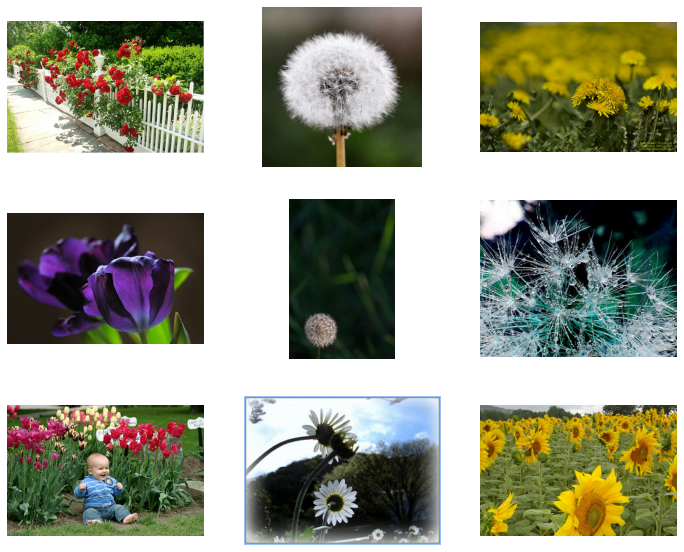

In [23]:
# ploting the images
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [75]:
# tf.dataset return data in X, y format
resize_rescale = tf.keras.models.Sequential([
            tf.keras.layers.Resizing(32, 32, crop_to_aspect_ratio=True),
            tf.keras.layers.Rescaling(1./255)
])

# Data augment layer
data_augment = tf.keras.models.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.2),

]) 

def preprocess(df, shuffle=False, augment=False):
    tdf = df.map(lambda X,y: (resize_rescale(X), y))
    if shuffle:
        tdf = tdf.shuffle(1_000,seed=42)
    # Batch all dataset
    tdf = tdf.batch(32)
    #Augmentation on training set: training=True means it will on apply during training
    if augment:
        tdf = tdf.map(lambda X,y: (data_augment(X, training=True), y))
    return tdf.prefetch(1)

train_data = preprocess(train_set_raw,True,True)
test_data  = preprocess(test_set_raw)
valid_data = preprocess(valid_set_raw)

In [82]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, activation="tanh",input_shape=(32,32,3)),
    tf.keras.layers.AveragePooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, activation="tanh"),
    tf.keras.layers.AveragePooling2D((2,2),strides=2), 
    tf.keras.layers.Conv2D(filters=120, kernel_size=5, strides=1, activation="tanh"),
    tf.keras.layers.Dense(84, activation='tanh'),
    tf.keras.layers.Dense(5, activation="softmax")    
])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
average_pooling2d_8 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_9 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 1, 120)         48120     
_________________________________________________________________
dense_8 (Dense)              (None, 1, 1, 84)          10164     
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1, 10)        

In [84]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])
hist = model.fit(train_data,validation_data=(valid_data), epochs=2)

Epoch 1/2
92/92 [==============================] - 4s 28ms/step - loss: 1.4420 - accuracy: 0.2149 - val_loss: 1.3270 - val_accuracy: 0.2015
Epoch 2/2
92/92 [==============================] - 2s 18ms/step - loss: 1.3107 - accuracy: 0.2162 - val_loss: 1.2612 - val_accuracy: 0.2025


In [85]:
score = model.evaluate(test_data)
score

12/12 [==============================] - 0s 19ms/step - loss: 1.2695 - accuracy: 0.2032


[1.269492745399475, 0.2032378762960434]